In [1]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import itertools
import pickle
import numpy as np
from numpy import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
from typing import TypeVar, Dict

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer

Tensor = TypeVar('torch.tensor')

#matplotlib.use('Agg')

import click
from argparse import Namespace
import ast
import os

import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from typing import TypeVar, Tuple
import gdown
import copy

no display found. Using non-interactive Agg backend


In [3]:
#@title Define Hyperparameters

# class_names = ["5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald", "Bangs",
#                 "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Blurry", "Brown_Hair", "Bushy_Eyebrows",
#                 "Chubby", "Double_Chin", "Eyeglasses", "Goatee", "Gray_Hair", "Heavy_Makeup", "High_Cheekbones",
#                 "Male", "Mouth_Slightly_Open", "Mustache", "Narrow_Eyes", "No_Beard", "Oval_Face", "Pale_Skin",
#                 "Pointy_Nose", "Receding_Hairline", "Rosy_Cheeks", "Sideburns", "Smiling", "Straight_Hair",
#                 "Wavy_Hair", "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace",
#                 "Wearing_Necktie", "Young"]
# num_classes = 40
# data_shape = [3, 64, 64]
# n_bits = 5
# temp = 0.7
# data_mean = [0.485, 0.456, 0.406]
# data_std = [0.229, 0.224, 0.225]

input_size = 28*28*1 # img_size = (28,28) ---> 28*28=784 in total
batch_size = 200 # the size of input data took for one iteration

In [4]:
# from torchvision.transforms import v2
# transform_RandomErasing=transforms.Compose([v2.RandomErasing(),
#                               transforms.ToTensor()])

transform=transforms.Compose([transforms.ToTensor()])

train_data = dsets.FashionMNIST(root = './data', train=True, transform = transform, download = True)
test_data = dsets.FashionMNIST(root = './data', train=False, transform = transform, download = True)

In [5]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)



In [6]:
#cvmx=torch.zeros([3*64*64,3*64*64],device=device)
images_list=[]
labels_list=[]
no_batches=len(train_gen)
#images_mean=torch.zeros(3,64,64,device=device)
for i ,(images,labels) in enumerate(train_gen):
    images = Variable(images).cuda().detach()
    labels=Variable(labels).cuda().detach()
    # images_mean=images_mean+images.mean(0)
    # im=torch.reshape(images,[images.shape[0],3*64*64])
    # cvmx+=torch.matmul(torch.transpose(im,0,1),im)
    if(i<(len(train_gen))):
        images_list.append(images)
        labels_list.append(labels)



test_images_list=[]
test_labels_list=[]
test_no_batches=len(test_gen)
for i ,(images,labels) in enumerate(test_gen):
    images = Variable(images).cuda().detach()
    labels=Variable(labels).cuda().detach()
    if(i<(len(test_gen))):
        test_images_list.append(images)
        test_labels_list.append(labels)

train_data_len=len(train_data)
test_data_len=len(test_data)



In [ ]:
#@title Define model class
import torch.nn as nn
import torch
import torch.nn.functional as F

from typing import TypeVar, Tuple

Tensor = TypeVar('torch.tensor')


class CNN(NeuralNet):
    """
    CNN for (binary) classification for CelebA, CheXpert
    """

    def __init__(self,
                 in_channels: int = 3,
                 num_classes: int = 2,
                 flattened_size: int = 16384,
                 low_rank: int = 32,
                 batch_norm_mom: float = 1.0):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.BatchNorm2d(32,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64,momentum=batch_norm_mom),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.BatchNorm2d(64,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.BatchNorm2d(128,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.BatchNorm2d(128),

            # nn.BatchNorm2d(128),
            # nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # nn.Softplus(beta=1.0),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.BatchNorm2d(128),

            # # Conv Layer block 2
            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            # nn.Softplus(beta=1.0),
            # nn.BatchNorm2d(128),
            # nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # nn.Softplus(beta=1.0),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.BatchNorm2d(128),

            # Conv Layer block 3
            nn.BatchNorm2d(128,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.BatchNorm2d(256,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            #nn.Dropout(p=0.1),
            nn.BatchNorm1d(flattened_size,momentum=batch_norm_mom),
#            nn.Linear(flattened_size, 512),
            nn.Linear(flattened_size, low_rank),
            nn.BatchNorm1d(low_rank,momentum=batch_norm_mom),
            nn.Linear(low_rank,512),            
            nn.Softplus(beta=1.0),
            nn.BatchNorm1d(512,momentum=batch_norm_mom),
            # nn.Linear(2048, 512),
            # nn.Softplus(beta=1.0),
            # nn.BatchNorm1d(512),
            # nn.Linear(1024, 512),
            # nn.Softplus(beta=1.0), 
            # nn.BatchNorm1d(512),
            #nn.Dropout(p=0.1),
        )

        self.last_layer=nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x: Tensor) -> Tensor:
        """Perform forward."""

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # # # fc layer
        x = self.fc_layer(x)

        x=self.last_layer(x)

        return x

    def classify(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        net_out = self.forward(x)
        acc = F.softmax(net_out, dim=1)
        class_idx = torch.max(net_out, 1)[1]

        return acc, acc[0, class_idx], class_idx
    




class CelebA_CNN(CNN):
    """CNN."""

    def __init__(self,
                 in_channels: int = 3,
                 num_classes: int = 2,
                 #num_classes: int = 1,
                 flattened_size: int = 16384):
        """CNN Builder."""
        super(CelebA_CNN, self).__init__(in_channels=in_channels, num_classes=num_classes,
                                         flattened_size=flattened_size)

class Fashion_MNIST_CNN(CNN):
    """CNN."""

    def __init__(self,
                 in_channels: int = 1,
                 num_classes: int = 10,
                 #flattened_size: int = 6272,
                 flattened_size: int = 2304,
                 low_rank: int = 64,
                 batch_norm_mom: float = 1.0):
        """CNN Builder."""
        super(Fashion_MNIST_CNN, self).__init__(in_channels=in_channels, num_classes=num_classes,
                                         flattened_size=flattened_size)




class CheXpert_CNN(CNN):
    def __init__(self,
                 in_channels: int = 1,
                 num_classes: int = 2,
                 flattened_size: int = 65536):
        """CNN Builder."""
        super(CheXpert_CNN, self).__init__(in_channels=in_channels, num_classes=num_classes,
                                           flattened_size=flattened_size)


class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [8]:
# net=Fashion_MNIST_CNN()
# n=0
# for par in net.parameters():
#     n+=par.numel()

# n

In [9]:
#@title Define loss-function & optimizer
loss_function = nn.CrossEntropyLoss()


def images_regulariser(): 
    li_reg_loss = 0
    penalized     = [p for name,p in net.named_parameters() if 'bias' not in name]
    not_penalized = [p for name,p in net.named_parameters() if 'bias' in name]
    for p in penalized:
        li_reg_loss += (p**2).sum()*0.5
    #for p in net.parameters():
#        li_reg_loss += (p**2).sum()*0.5
    reg=li_reg_loss/(train_data_len)*l2regconst
    return(reg)


In [10]:
def addnet(net,net2):
    for param1, param2 in zip(net.parameters(), net2.parameters()):
     param1.data += param2.data

def multiplynet(net,a):
   for param1 in net.parameters():
     param1.data *=a

In [11]:
from dataclasses import dataclass
@dataclass
class hclass:
    h: Tensor
    eta: Tensor
    etam1g: Tensor
    c11: Tensor
    c21: Tensor
    c22: Tensor

def hper2const(h,gam):
    gh=gam.double()*h.double()
    s=torch.sqrt(4*torch.expm1(-gh/2)-torch.expm1(-gh)+gh)
    eta=(torch.exp(-gh/2)).float()
    etam1g=((-torch.expm1(-gh/2))/gam.double()).float()
    c11=(s/gam).float()
    c21=(torch.exp(-gh)*(torch.expm1(gh/2.0))**2/s).float()
    c22=(torch.sqrt(8*torch.expm1(-gh/2)-4*torch.expm1(-gh)-gh*torch.expm1(-gh))/s).float()
    hc=hclass(h=h,eta=eta,etam1g=etam1g,c11=c11,c21=c21,c22=c22)
    return(hc)

def U(x,v,hc):
    xi1=torch.randn(x.size(),device=device)
    xi2=torch.randn(x.size(),device=device)

    xn=x+hc.etam1g*v+hc.c11*xi1
    vn=v*hc.eta+hc.c21*xi1+hc.c22*xi2
    return([xn, vn])

def bounce(x,v,xstar,width):
    vsign=(((x-xstar+width)/(2*width)).floor()% 2)*(-2)+1
    vn=v*vsign
    xn=((x-xstar-width)% (4*width)-2*width).abs()-width+xstar
    # num_outside=((xn-xstar)>width).sum()+((xstar-xn)>width).sum()
    # if(num_outside>0):
    #     print(num_outside)    
    return([xn, vn])

def bouncenet():
    for p,p_star in zip(net.parameters(),net_star.parameters()):
        [p.data, p.v]=bounce(p.data, p.v, p_star.data, 6/torch.sqrt(l2regconst_extra))

def svrg_grad(net, batch_it):
    outputsU = net(images_list[batch_it])
    loss_likelihood = loss_function(outputsU, labels_list[batch_it])  


    grads_reg=[torch.zeros_like(par) for par in net.parameters()]
    net_pars=list(net.parameters())
    with torch.no_grad():
        for it in range(len_params):
            if(list_no_bias[it]):
                grads_reg[it]=net_pars[it].data*l2regconst

    net.zero_grad()
    loss_likelihood.backward()
    with torch.no_grad():
        grads_likelihood=[par.grad*batch_size for par in net.parameters()]

        svrg_grads=[]
        for p,grad,grad_reg,p_star,grad_star,star_sum_grad in zip(list(net.parameters()),grads_likelihood,grads_reg,list(net_star.parameters()),net_star_grad_list[batch_it],net_star_full_grad):              
            svrg_grads.append(grad_reg+star_sum_grad+(grad-grad_star)*no_batches+l2regconst_extra*(p.data-p_star.data))
    return svrg_grads,loss_likelihood.data

def EM_step(net, h, gam,batch_it):   
    svrg_grads,loss_likelihood_data=svrg_grad(net, batch_it)   

    with torch.no_grad():
        for p,gradp in zip(net.parameters(), svrg_grads):              
            p.xi=torch.randn_like(p.data,device=device)
            p.data+=p.v*h
            p.v-=(h)*gradp+gam*(h)*p.v-torch.sqrt(2*gam*h)*p.xi

    return(loss_likelihood_data)

def UBU_step(hper2c,images,labels,batch_it):   
    with torch.no_grad():
        for p in list(net.parameters()):
            # maxlen=20*torch.sqrt((torch.tensor(torch.numel(p.v))).float())
            # if(torch.norm(p.v)>maxlen):
            #    print("big trouble!!!!")    
            [p.data,p.v]=U(p.data,p.v,hper2c)

        #bouncenet()
    #print("outputsU",len(outputsU))
    #print("labelsU",len(labels))
    #print("imagesU",len(images))
    outputsU = net(images)
    loss_likelihood = loss_function(outputsU, labels)  


    grads_reg=[torch.zeros_like(par) for par in net.parameters()]
    net_pars=list(net.parameters())
    with torch.no_grad():
        for it in range(len_params):
            if(list_no_bias[it]):
                grads_reg[it]=net_pars[it].data*l2regconst

    net.zero_grad()
    #loss.backward()
    loss_likelihood.backward()
    with torch.no_grad():
        grads_likelihood=[par.grad*batch_size for par in net.parameters()]
    
        #Normal, no variance reduction
        # for p,p_star in zip(net.parameters(),net_star.parameters()):      
        #     p.v-=hper2c.h*(p.grad*train_data_len+l2regconst_extra*(p.data-p_star.data))

        for p,grad,grad_reg,p_star,grad_star,star_sum_grad in zip(list(net.parameters()),grads_likelihood,grads_reg,list(net_star.parameters()),net_star_grad_list[batch_it],net_star_full_grad):              
            #Using variance reduction
            p.v-=hper2c.h*(grad_reg+star_sum_grad+(grad-grad_star)*no_batches+l2regconst_extra*(p.data-p_star.data))

            # maxlen=20*torch.sqrt((torch.tensor(torch.numel(p.v))).float())
            # if(torch.norm(p.v)>maxlen):
            #     print("trouble")
                #p.v=(p.v/torch.norm(p.v))*maxlen
        # for it in range(len_params):
        #     [list(net.parameters())[it].data,list(net.parameters())[it].v]=U(list(net.parameters())[it].data,list(net.parameters())[it].v,hper2c)        
        for p in list(net.parameters()):
            [p.data,p.v]=U(p.data,p.v,hper2c)

    #bouncenet()
    return(loss_likelihood.data)

def ind_create(batch_it):
    modit=batch_it %(2*no_batches)
    ind=(modit<=(no_batches-1))*modit+(modit>=no_batches)*(2*no_batches-modit-1)
    return ind

In [12]:
#net = Fashion_MNIST_CNN().cuda()
#net2=copy.deepcopy(net)
#addnet(net2,net)
#multiplynet(net2,1/10)

In [13]:
# filepath="output_fashion_low_rank_9n.pickle"
# #filepath="output_fashion_low_rank_long.pickle"
# with open(filepath,"rb") as file:
#    [labels_arr,test_labels_arr,test_prob_arr]=pickle.load(file)
# labels_arr=torch.tensor(labels_arr).detach()
# test_labels_arr=torch.tensor(test_labels_arr).detach()
# test_prob_arr=torch.tensor(test_prob_arr).detach()

In [14]:
#@title Output arrays
par_runs=64
num_classes=10
num_epochs=60
switch_to_sampling_epoch=20
switch_to_swag_epoch=15

num_swag_epochs=switch_to_sampling_epoch-switch_to_swag_epoch

training_size=no_batches*batch_size
test_size=test_data_len
labels_arr=torch.zeros(training_size)
test_labels_arr=torch.zeros(test_size)
test_prob_arr=torch.zeros([test_size,num_classes,num_epochs,par_runs])

lr = 1e-2
lr_swag=1e-3
h=2.5e-4
l2regconst=torch.tensor(1).detach()
l2regconst_extra=torch.tensor(0).detach()
gam=torch.sqrt(torch.tensor(50)).detach()
hper2c=hper2const(torch.tensor(h/2),gam)

for par_it in range(par_runs):
  print("par_it:",par_it,"\n")
  #@title Build the model
  net = Fashion_MNIST_CNN().cuda()
  net.train()
  optimizer = torch.optim.Adam( net.parameters(), lr=lr)
  
  lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer=optimizer, total_iters=switch_to_swag_epoch,power=1)


  #@title Training the model

  for epoch in range(num_epochs):
    sum_loss=0
    #l2regconst=torch.min(torch.tensor(1+epoch),torch.tensor(switch_to_swag_epoch)).detach()
    net.train()
    if(epoch==(switch_to_swag_epoch-1)):
      net_star2=copy.deepcopy(net)
      net2=copy.deepcopy(net)
      multiplynet(net2,0)
      optimizer=torch.optim.Adam(net.parameters(),lr=lr_swag)

    if(epoch>=switch_to_sampling_epoch and (epoch-switch_to_sampling_epoch)%2==0):
        rperm=random.permutation(list(range(no_batches)))
    
    for i in range(no_batches): 
      b=torch.randint(high=no_batches,size=(1,1))
      images=images_list[b]
      labels=labels_list[b]
      
      # outputs = net(images)    
      # loss = loss_function(outputs, labels)
      # sum_loss=sum_loss+loss    
      # reg=images_regulariser()
      # loss=loss+reg
      # optimizer.zero_grad()
      # loss.backward()
      # optimizer.step()
      # sum_loss_tot=sum_loss_tot+loss


      if(epoch<switch_to_sampling_epoch):
        outputs = net(images)    
        loss_likelihood = loss_function(outputs, labels)
        sum_loss=sum_loss+loss_likelihood    
        reg=images_regulariser()
        loss=loss_likelihood+reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(epoch>=(switch_to_swag_epoch)):
          addnet(net2,net)
      else:
        loss_likelihood=EM_step(net, h, gam,b)
        #UBU_step(hper2c,images,labels,b)
        sum_loss=sum_loss+loss_likelihood




    #if (i+1) % (no_batches) == 0:
    #print("Reg:",reg)
    print('Epoch [%d/%d], Step [%d/%d]' %(epoch+1, num_epochs, i+1, no_batches))
    correct = 0
    total = 0
    





    #for imagest,labelst in eval_gen:
    if epoch==(switch_to_sampling_epoch-1):
      multiplynet(net2,1/(num_swag_epochs*no_batches))
      multiplynet(net,0)
      addnet(net,net2)
      del net2

      net_star=copy.deepcopy(net)
      len_params=len(list(net_star.parameters()))

      #Variance reduction - saving gradients at each batch at x_star
      net_star_grad_list=[]
      net_star_full_grad=[torch.zeros_like(par, device=device) for par in list(net_star.parameters())]
      for i in range(no_batches):
          images=images_list[i]
          labels=labels_list[i]
          outputs=net_star(images)
          loss_likelihood = loss_function(outputs, labels)
          reg=images_regulariser()
          net_star.zero_grad()
          loss_likelihood.backward()
          grads=[par.grad*batch_size for par in list(net_star.parameters())]
          net_star_grad_list.append(grads)
          for g, gi in zip(net_star_full_grad,grads):
            g+=gi          

      len_params=len(list(net_star.parameters()))
      list_no_bias=torch.zeros(len_params)
      pit=0
      for name, p in net_star.named_parameters():
          if 'bias' not in name:
              list_no_bias[pit]=1.0
          pit+=1

      #Initialise velocities
      for par in list(net.parameters()):
        par.v = torch.randn_like(par,device=device)      


    with torch.no_grad():
      net(torch.cat(images_list[0:20],dim=0).detach())        
      net.eval()

      # for mod in list(net.named_modules()):
      #   if(hasattr(mod[1],"momentum")):
      #     mod[1].momentum=None
      # for i in range(no_batches):
      #   net(images_list[i].detach())
      # net.eval()

      for testit in range(test_no_batches):
        imagest=test_images_list[testit]
        labelst=test_labels_list[testit]
        actual_batch_size=len(imagest)
        test_labels_arr[(testit*batch_size):(testit*batch_size+actual_batch_size)]=labelst.detach().cpu()
        outputt = net(imagest).detach()#.reshape(actual_batch_size).detach()
        _, predictedt = torch.max(outputt,1)

        correct += (predictedt == labelst).sum()
        total += labelst.size(0)

        test_prob_arr[(testit*batch_size):(testit*batch_size+actual_batch_size),:,epoch,par_it]=torch.softmax(outputt,dim=1)
    


    

    #net.train()       
    print('Test accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

    if(epoch<=switch_to_swag_epoch):
      lr_scheduler.step()
    print('Epoch [%d], Average Loss: %0.4f' %(epoch+1, sum_loss/no_batches))
    
    # for mod in list(net.named_modules()):
    #   if(hasattr(mod[1],"momentum")):
    #     mod[1].momentum=1.0
  
  filepath="output_fashion_SG_HMC.pickle"
  with open(filepath,"wb") as file:
    pickle.dump([labels_arr.numpy(),test_labels_arr.numpy(),test_prob_arr.numpy()],file)





par_it: 0 

Epoch [1/60], Step [300/300]
Test accuracy of the model: 86.661 %
Epoch [1], Average Loss: 0.5508
Epoch [2/60], Step [300/300]
Test accuracy of the model: 90.321 %
Epoch [2], Average Loss: 0.2899
Epoch [3/60], Step [300/300]
Test accuracy of the model: 90.481 %
Epoch [3], Average Loss: 0.2468
Epoch [4/60], Step [300/300]
Test accuracy of the model: 91.311 %
Epoch [4], Average Loss: 0.2185
Epoch [5/60], Step [300/300]
Test accuracy of the model: 91.821 %
Epoch [5], Average Loss: 0.1872
Epoch [6/60], Step [300/300]
Test accuracy of the model: 92.121 %
Epoch [6], Average Loss: 0.1742
Epoch [7/60], Step [300/300]
Test accuracy of the model: 91.921 %
Epoch [7], Average Loss: 0.1494
Epoch [8/60], Step [300/300]
Test accuracy of the model: 92.161 %
Epoch [8], Average Loss: 0.1381
Epoch [9/60], Step [300/300]
Test accuracy of the model: 92.401 %
Epoch [9], Average Loss: 0.1299
Epoch [10/60], Step [300/300]
Test accuracy of the model: 92.041 %
Epoch [10], Average Loss: 0.1067
Epoch 

In [15]:
n=0
for par in net.parameters():
    n+=par.numel()
n

1265258

In [16]:
net_star_backup=copy.deepcopy(net_star)

In [17]:
# #net_star=Fashion_MNIST_CNN().cuda()
# #net_star=net
# net_star=copy.deepcopy(net_star_backup)
# net_star.train()
# with torch.no_grad():
#     for par in net_star.parameters():
#         par+=(torch.rand_like(par)*2-1)*6/torch.sqrt(l2regconst_extra)

# len_params=len(list(net_star.parameters()))
# list_no_bias=torch.zeros(len_params)
# it=0
# for name, p in net_star.named_parameters():
#     if 'bias' not in name:
#         list_no_bias[it]=1.0
#     it+=1

# # def grad_vec(vec):   
# #     net_star_copy=copy.deepcopy(net_star)
# #     for it in range(len_params):
# #         list(net_star_copy.parameters())[it]=vec[it]
# #         list(net_star_copy.parameters())[it].requires_grad=True
# #     out=net_star_copy(images)
# #     loss=loss_function(out,labels)*train_data_len    
# #     net_star_copy.zero_grad()
# #     loss.backward()
# #     grad=[p.grad for p in net_star_copy.parameters()]
# #     # pars = list(net_star_copy.parameters())
# #     # out=net_star_copy(images)
# #     # loss=loss_function(out,labels)*train_data_len    
# #     # net_star_copy.zero_grad()
# #     # grad=list(torch.autograd.grad(loss,pars,create_graph=False))
# #     # with torch.no_grad():
# #     #     for it in range(len_params):
# #     #         if(list_no_bias[it]):
# #     #             grad[it]+=vec[it]*l2regconst
# #     return(grad)

# # def grad_vec_full(vec):
# #     gradfull=copy.deepcopy(list(vec))
# #     for p in gradfull:
# #         p.requires_grad=False
# #         p*=0
# #     len_pars=len(list(vec))
# #     for it in range(no_batches):
# #         images=images_list[it]
# #         labels=labels_list[it]
# #         grad=grad_vec(vec)
# #         for pit in range(len_pars):
# #             gradfull[pit]+=grad[pit]
# #     return(gradfull)

# def hess_vec(vec,images,labels):   
#     out=net_star(images)
#     loss=loss_function(out,labels)*batch_size
#     net_star.zero_grad()
#     grad=list(torch.autograd.grad(loss,list(net_star.parameters()),create_graph=True))
#     res=torch.zeros(1).cuda()
#     for it in range(len_params):
#         res+=(grad[it]*vec[it]).sum()
#     net_star.zero_grad()
#     hvp=list(torch.autograd.grad(res,list(net_star.parameters()),create_graph=False))

#     return(hvp)
    
#     # hvp_with_prior=copy.deepcopy(hvp)
#     # l2regnewconst=torch.tensor(1e3)
#     # for p,v in zip(hvp_with_prior,vec):
#     #     p+=l2regnewconst*v
#     # return(hvp_with_prior)
# def hess_vec_full(vec):
#     hvfull=copy.deepcopy(list(vec))
#     for p in hvfull:
#         p.requires_grad=False
#         p*=0
#     len_pars=len(hvfull)
#     for it in range(no_batches):
#         images=images_list[it]
#         labels=labels_list[it]
#         hv=hess_vec(vec,images,labels)
#         for pit in range(len_pars):
#             hvfull[pit]+=hv[pit]
#     for pit in range(len_pars):
#         hvfull[pit]+=list(vec)[pit]*l2regconst_extra
#         if(list_no_bias[pit]):
#             hvfull[pit]+=list(vec)[pit]*l2regconst
#     return(hvfull)

# def norm_par(vec):
#     n=torch.zeros(1).detach().cuda()
#     for p in vec:
#         n+=p.pow(2).sum()
#     return n.sqrt()

# def multiply_par(vec,c):
#     res_vec=copy.deepcopy(vec)
#     for it in range(len_params):
#         res_vec[it].requires_grad=False
#         res_vec[it]=res_vec[it]*c
#     return res_vec

# def scalar_prod_par(vec1,vec2):
#     res=torch.zeros(1).cuda()
#     for it in range(len_params):
#         res+=(vec1[it]*vec2[it]).sum()
#     return res

# def add_par(vec1,vec2):
#     res_vec=copy.deepcopy(vec1)
#     for it in range(len_params):
#         res_vec[it].requires_grad=False
#         res_vec[it]=vec1[it]+vec2[it]
#     return res_vec

# # print(norm_par(list(net_star.parameters())))
# # print(norm_par(multiply_par(list(net_star.parameters()),0.1)))

# vec=copy.deepcopy(list(net_star.parameters()))
# for p in vec:
#     p.requires_grad=False
# norm_iter=norm_par(vec)
# vec=multiply_par(vec,torch.Tensor(1/norm_iter))
# for iter in range(10):
#     vec=hess_vec_full(vec)
#     norm_iter=norm_par(vec)
#     vec=multiply_par(vec,1/norm_iter)    
#     print(norm_iter)

# max_eigen_vec=copy.deepcopy(vec)
# max_eigen=norm_iter

# vec=copy.deepcopy(list(net_star.parameters()))
# for p in vec:
#     p.requires_grad=False
# vec=add_par(vec,multiply_par(max_eigen_vec,-scalar_prod_par(vec,max_eigen_vec)))
# norm_iter=norm_par(vec)
# vec=multiply_par(vec,torch.Tensor(1/norm_iter))

# for iter in range(10):
#     vec=hess_vec_full(vec)
#     vec=add_par(vec,multiply_par(max_eigen_vec,-scalar_prod_par(vec,max_eigen_vec)))
#     norm_iter=norm_par(vec)
#     vec=multiply_par(vec,1/norm_iter)    
#     print(norm_iter)


In [18]:
#filepath="output_fashion.pickle"
#with open(filepath,"rb") as file:
#    [labels_arr,test_labels_arr,test_prob_arr,_,_]=pickle.load(file)
#labels_arr=torch.tensor(labels_arr).detach()
#test_labels_arr=torch.tensor(test_labels_arr).detach()
#test_prob_arr=torch.tensor(test_prob_arr).detach()

In [19]:
# Outcome should be a binary list of the ordinal outcome. [0, 1, 0] for exmaple.
# Probs should be a list of probabilities. [0.79, 0.09, 0.12] for example.
# Outcome and Probs must be provided with the same order as probabilities.

def rps_single(probs, true_label):
    outcome=torch.zeros(num_classes)
    outcome[true_label.int()]=1.0
    cum_probs = torch.cumsum(probs,0)
    cum_outcomes = torch.cumsum(outcome,0)
    
    #print(cum_outcomes)
    #print(cum_probs)
    sum_rps = 0
    for i in range(len(outcome)):         
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2
    
    return sum_rps/(num_classes-1)

def rps_calc(test_probs, true_labels):
    rps_vec=torch.zeros(test_data_len)
    for it in range(test_data_len):
        rps_vec[it]=rps_single(test_probs[it,:].reshape(num_classes),true_labels[it])
    return rps_vec

def nll_calc(test_probs, true_labels):
    res=0
    for it in range(test_data_len):
        res-=torch.max(torch.tensor([torch.log(test_probs[it,true_labels[it].int()]),-100]))
    return res/test_data_len

def adaptive_calibration_error(test_probs,true_labels, num_bins=20):
    max_probs, predicted_labels = torch.max(test_probs,1)
    ind=torch.argsort(max_probs,stable=True)
    sorted_max_probs=max_probs[ind]
    sorted_predicted_labels=predicted_labels[ind]
    sorted_true_labels=true_labels[ind]

    correct = (sorted_predicted_labels == sorted_true_labels).clone().detach().float()
    bins=(torch.tensor(range(test_data_len))/torch.tensor(test_data_len/num_bins)).floor()

    o=torch.tensor(0.0)
    for b in range(num_bins):
        mask = (bins == b)
        if torch.any(mask):
            #print(b, sorted_max_probs[mask].mean(), (correct[mask] - sorted_max_probs[mask]).mean())
            o += (correct[mask] - sorted_max_probs[mask]).mean().abs()

    return o / num_bins

In [20]:
def GRdiagnostics(res):
  J=res.shape[0] #Number of chains
  L=res.shape[1] #Number of samples after burnin
  res_means=res.mean(dim=1)
  res_mean=res_means.mean()
  B=(res_means-res_mean).pow(2).sum()*L/(J-1)
  W=(res_means.reshape([J,1])@torch.ones([1,L])-res).pow(2).sum()/(J*(L-1))
  R=(W*(L-1)/L+B/L)/W
  return R


par_chains=4
no_GR_epochs=40
test_prob_GR_arr=torch.zeros([test_size,num_classes])
nll_GR_arr=torch.zeros([par_chains,no_GR_epochs])
for chain in range(par_chains):
    net=copy.deepcopy(net_star)
    with torch.no_grad():
      for par in net.parameters():
        par+=(torch.randn_like(par))/torch.sqrt(torch.tensor(4))
        par.v = torch.randn_like(par,device=device)
    for par in list(net.parameters()):
      par.v = torch.randn_like(par,device=device)          
    for epoch in range(no_GR_epochs):
      print("chain: ",chain, "/epoch:",epoch)
      # if(epoch % 2 == 1):
      #   irange=range(no_batches-1,-1,-1)
      # else:
      #   irange=range(no_batches)
      # for b in irange:
      #   images=images_list[b]
      #   labels=labels_list[b]
      for it in range(batch_size):
        b=torch.randint(high=no_batches,size=(1,1))        
        EM_step(net, h, gam,b)

      for testit in range(test_no_batches):
        imagest=test_images_list[testit]
        labelst=test_labels_list[testit]
        actual_batch_size=len(imagest)
        outputt = net(imagest).detach()
        test_prob_GR_arr[(testit*batch_size):(testit*batch_size+actual_batch_size),:]=torch.softmax(outputt,dim=1)
      
      nll_GR_arr[chain,epoch]=nll_calc(test_prob_GR_arr,test_labels_arr)
      print("NLL:", nll_GR_arr[chain,epoch])

print(GRdiagnostics(nll_GR_arr))

chain:  0 /epoch: 0
NLL: tensor(2.2595)
chain:  0 /epoch: 1
NLL: tensor(3.2714)
chain:  0 /epoch: 2
NLL: tensor(3.9557)
chain:  0 /epoch: 3
NLL: tensor(4.4849)
chain:  0 /epoch: 4
NLL: tensor(4.3363)
chain:  0 /epoch: 5
NLL: tensor(3.9835)
chain:  0 /epoch: 6
NLL: tensor(5.3242)
chain:  0 /epoch: 7
NLL: tensor(3.3267)
chain:  0 /epoch: 8
NLL: tensor(3.2231)
chain:  0 /epoch: 9
NLL: tensor(3.9681)
chain:  0 /epoch: 10
NLL: tensor(4.1702)
chain:  0 /epoch: 11
NLL: tensor(3.9891)
chain:  0 /epoch: 12
NLL: tensor(3.8212)
chain:  0 /epoch: 13
NLL: tensor(3.0601)
chain:  0 /epoch: 14
NLL: tensor(3.1426)
chain:  0 /epoch: 15
NLL: tensor(3.3896)
chain:  0 /epoch: 16
NLL: tensor(2.3290)
chain:  0 /epoch: 17
NLL: tensor(2.2624)
chain:  0 /epoch: 18
NLL: tensor(2.2708)
chain:  0 /epoch: 19
NLL: tensor(2.3081)
chain:  0 /epoch: 20
NLL: tensor(2.4802)
chain:  0 /epoch: 21
NLL: tensor(2.0481)
chain:  0 /epoch: 22
NLL: tensor(2.8352)
chain:  0 /epoch: 23
NLL: tensor(1.2631)
chain:  0 /epoch: 24
NLL: 

In [21]:
print(GRdiagnostics(nll_GR_arr[:,10:40]))

tensor(2.1597)


In [22]:
#test_prob=torch.Tensor(test_prob_arr[:,:,29,0]).reshape(test_size,num_classes)
#torch.cumsum(test_prob[1,:].reshape(num_classes),0)
#rps_single(test_prob[1,:].reshape(num_classes),test_labels_arr[1])


In [23]:
#no bayesian
par_runs=64
def compute_acc_ace_rps_no_bayes(es):
    copies=int(par_runs/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,14,it*es:(it+1)*es]).mean(-1).reshape(test_size,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_size)).sum()/test_size
    print("Non-Bayesian, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]

acc=torch.zeros(5)
acc_std=torch.zeros(5)
ace=torch.zeros(5)
ace_std=torch.zeros(5)
rps=torch.zeros(5)
rps_std=torch.zeros(5)
nll=torch.zeros(5)
nll_std=torch.zeros(5)
[acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0],nll[0],nll_std[0]]=compute_acc_ace_rps_no_bayes(1)
[acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1],nll[1],nll_std[1]]=compute_acc_ace_rps_no_bayes(2)
[acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2],nll[2],nll_std[2]]=compute_acc_ace_rps_no_bayes(4)
[acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3],nll[3],nll_std[3]]=compute_acc_ace_rps_no_bayes(8)
[acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4],nll[4],nll_std[4]]=compute_acc_ace_rps_no_bayes(16)

from scipy.io import savemat
filepath="results_fashion_no_bayes_SG_HMC.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
      "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

Non-Bayesian, ensemble size: 1
mean accuracy: tensor(0.9304) std: tensor(0.0022)
mean ace: tensor(0.0468) std: tensor(0.0023)
mean nll: tensor(0.3279) std: tensor(0.0180)
mean rps: tensor(0.0217) std: tensor(0.0006)
Non-Bayesian, ensemble size: 2
mean accuracy: tensor(0.9392) std: tensor(0.0017)
mean ace: tensor(0.0223) std: tensor(0.0023)
mean nll: tensor(0.2338) std: tensor(0.0086)
mean rps: tensor(0.0180) std: tensor(0.0004)
Non-Bayesian, ensemble size: 4
mean accuracy: tensor(0.9438) std: tensor(0.0014)
mean ace: tensor(0.0125) std: tensor(0.0014)
mean nll: tensor(0.1914) std: tensor(0.0061)
mean rps: tensor(0.0162) std: tensor(0.0004)
Non-Bayesian, ensemble size: 8
mean accuracy: tensor(0.9462) std: tensor(0.0012)
mean ace: tensor(0.0087) std: tensor(0.0006)
mean nll: tensor(0.1706) std: tensor(0.0044)
mean rps: tensor(0.0153) std: tensor(0.0003)
Non-Bayesian, ensemble size: 16
mean accuracy: tensor(0.9478) std: tensor(0.0007)
mean ace: tensor(0.0063) std: tensor(0.0008)
mean nll:

Non-Bayesian, ensemble size: 1
mean accuracy: tensor(0.9296) std: tensor(0.0020)
mean ace: tensor(0.0555) std: tensor(0.0018)
mean nll: tensor(0.4709) std: tensor(0.0251)
mean rps: tensor(0.0230) std: tensor(0.0008)
Non-Bayesian, ensemble size: 2
mean accuracy: tensor(0.9383) std: tensor(0.0015)
mean ace: tensor(0.0294) std: tensor(0.0016)
mean nll: tensor(0.3109) std: tensor(0.0127)
mean rps: tensor(0.0188) std: tensor(0.0005)
Non-Bayesian, ensemble size: 4
mean accuracy: tensor(0.9422) std: tensor(0.0010)
mean ace: tensor(0.0177) std: tensor(0.0011)
mean nll: tensor(0.2385) std: tensor(0.0066)
mean rps: tensor(0.0168) std: tensor(0.0003)
Non-Bayesian, ensemble size: 8
mean accuracy: tensor(0.9443) std: tensor(0.0006)
mean ace: tensor(0.0126) std: tensor(0.0007)
mean nll: tensor(0.2025) std: tensor(0.0042)
mean rps: tensor(0.0157) std: tensor(0.0002)
Non-Bayesian, ensemble size: 16
mean accuracy: tensor(0.9459) std: tensor(0.0009)
mean ace: tensor(0.0098) std: tensor(0.0007)
mean nll: tensor(0.1832) std: tensor(0.0029)
mean rps: tensor(0.0152) std: tensor(8.2395e-05)

In [ ]:
#swa
def compute_acc_ace_rps_swa(es):
    copies=int(par_runs/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,19,it*es:(it+1)*es]).mean(-1).reshape(test_size,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_size)).sum()/test_size
    print("SWA, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]

acc=torch.zeros(5)
acc_std=torch.zeros(5)
ace=torch.zeros(5)
ace_std=torch.zeros(5)
rps=torch.zeros(5)
rps_std=torch.zeros(5)
nll=torch.zeros(5)
nll_std=torch.zeros(5)
[acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0],nll[0],nll_std[0]]=compute_acc_ace_rps_swa(1)
[acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1],nll[1],nll_std[1]]=compute_acc_ace_rps_swa(2)
[acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2],nll[2],nll_std[2]]=compute_acc_ace_rps_swa(4)
[acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3],nll[3],nll_std[3]]=compute_acc_ace_rps_swa(8)
[acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4],nll[4],nll_std[4]]=compute_acc_ace_rps_swa(16)

from scipy.io import savemat
filepath="results_fashion_swa_SG_HMC.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
      "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

SWA, ensemble size: 1
mean accuracy: tensor(0.9356) std: tensor(0.0015)
mean ace: tensor(0.0459) std: tensor(0.0016)
mean nll: tensor(0.3383) std: tensor(0.0126)
mean rps: tensor(0.0207) std: tensor(0.0005)
SWA, ensemble size: 2
mean accuracy: tensor(0.9420) std: tensor(0.0013)
mean ace: tensor(0.0256) std: tensor(0.0013)
mean nll: tensor(0.2467) std: tensor(0.0063)
mean rps: tensor(0.0176) std: tensor(0.0003)
SWA, ensemble size: 4
mean accuracy: tensor(0.9453) std: tensor(0.0011)
mean ace: tensor(0.0174) std: tensor(0.0010)
mean nll: tensor(0.2038) std: tensor(0.0049)
mean rps: tensor(0.0160) std: tensor(0.0002)
SWA, ensemble size: 8
mean accuracy: tensor(0.9474) std: tensor(0.0009)
mean ace: tensor(0.0132) std: tensor(0.0008)
mean nll: tensor(0.1816) std: tensor(0.0026)
mean rps: tensor(0.0152) std: tensor(0.0001)
SWA, ensemble size: 16
mean accuracy: tensor(0.9489) std: tensor(0.0005)
mean ace: tensor(0.0107) std: tensor(0.0004)
mean nll: tensor(0.1700) std: tensor(0.0020)
mean rps:

SWA, ensemble size: 1
mean accuracy: tensor(0.9337) std: tensor(0.0016)
mean ace: tensor(0.0537) std: tensor(0.0016)
mean nll: tensor(0.4826) std: tensor(0.0191)
mean rps: tensor(0.0220) std: tensor(0.0006)
SWA, ensemble size: 2
mean accuracy: tensor(0.9403) std: tensor(0.0012)
mean ace: tensor(0.0309) std: tensor(0.0012)
mean nll: tensor(0.3312) std: tensor(0.0111)
mean rps: tensor(0.0184) std: tensor(0.0004)
SWA, ensemble size: 4
mean accuracy: tensor(0.9435) std: tensor(0.0011)
mean ace: tensor(0.0223) std: tensor(0.0010)
mean nll: tensor(0.2579) std: tensor(0.0078)
mean rps: tensor(0.0166) std: tensor(0.0003)
SWA, ensemble size: 8
mean accuracy: tensor(0.9453) std: tensor(0.0008)
mean ace: tensor(0.0180) std: tensor(0.0011)
mean nll: tensor(0.2186) std: tensor(0.0036)
mean rps: tensor(0.0157) std: tensor(0.0002)
SWA, ensemble size: 16
mean accuracy: tensor(0.9462) std: tensor(0.0008)
mean ace: tensor(0.0158) std: tensor(0.0009)
mean nll: tensor(0.1964) std: tensor(0.0034)
mean rps: tensor(0.0153) std: tensor(5.5335e-05)

In [ ]:
#Bayesian
def compute_acc_ace_rps_bayes(es):
    copies=int(par_runs/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,30:60,it*es:(it+1)*es]).mean(-1).mean(-1).reshape(test_size,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_size)).sum()/test_size
    print("Bayesian, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]



acc=torch.zeros(5)
acc_std=torch.zeros(5)
ace=torch.zeros(5)
ace_std=torch.zeros(5)
rps=torch.zeros(5)
rps_std=torch.zeros(5)
nll=torch.zeros(5)
nll_std=torch.zeros(5)
[acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0],nll[0],nll_std[0]]=compute_acc_ace_rps_bayes(1)
[acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1],nll[1],nll_std[1]]=compute_acc_ace_rps_bayes(2)
[acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2],nll[2],nll_std[2]]=compute_acc_ace_rps_bayes(4)
[acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3],nll[3],nll_std[3]]=compute_acc_ace_rps_bayes(8)
[acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4],nll[4],nll_std[4]]=compute_acc_ace_rps_bayes(16)

from scipy.io import savemat
filepath="results_fashion_bayes_SG_HMC.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
      "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

Bayesian, ensemble size: 1
mean accuracy: tensor(0.9312) std: tensor(0.0015)
mean ace: tensor(0.0166) std: tensor(0.0021)
mean nll: tensor(0.1955) std: tensor(0.0025)
mean rps: tensor(0.0189) std: tensor(0.0002)
Bayesian, ensemble size: 2
mean accuracy: tensor(0.9345) std: tensor(0.0010)
mean ace: tensor(0.0217) std: tensor(0.0017)
mean nll: tensor(0.1883) std: tensor(0.0014)
mean rps: tensor(0.0183) std: tensor(0.0001)
Bayesian, ensemble size: 4
mean accuracy: tensor(0.9360) std: tensor(0.0008)
mean ace: tensor(0.0242) std: tensor(0.0012)
mean nll: tensor(0.1850) std: tensor(0.0009)
mean rps: tensor(0.0180) std: tensor(9.6171e-05)
Bayesian, ensemble size: 8
mean accuracy: tensor(0.9365) std: tensor(0.0007)
mean ace: tensor(0.0252) std: tensor(0.0009)
mean nll: tensor(0.1833) std: tensor(0.0006)
mean rps: tensor(0.0178) std: tensor(6.9177e-05)
Bayesian, ensemble size: 16
mean accuracy: tensor(0.9373) std: tensor(0.0010)
mean ace: tensor(0.0262) std: tensor(0.0013)
mean nll: tensor(0.18

Bayesian, ensemble size: 1
mean accuracy: tensor(0.9358) std: tensor(nan)
mean ace: tensor(0.0123) std: tensor(nan)
mean nll: tensor(0.2039) std: tensor(nan)
mean rps: tensor(0.0177) std: tensor(nan)

Bayesian, ensemble size: 1
mean accuracy: tensor(0.9400) std: tensor(nan)
mean ace: tensor(0.0072) std: tensor(nan)
mean nll: tensor(0.1876) std: tensor(nan)
mean rps: tensor(0.0169) std: tensor(nan)


In [26]:
# test_prob=torch.Tensor(test_prob_arr[:,7,0]).reshape(test_size,1)
# ace=adaptive_calibration_error(test_labels_arr.reshape(test_size,1).numpy(),test_prob.numpy(),20)
# ace

In [27]:
# test_prob=torch.Tensor(test_prob_arr[:,10:16,48:64]).mean(-1).mean(-1).reshape(test_size,1)
# ace=adaptive_calibration_error(test_labels_arr.reshape(test_size,1).numpy(),test_prob.numpy(),20)
# ace

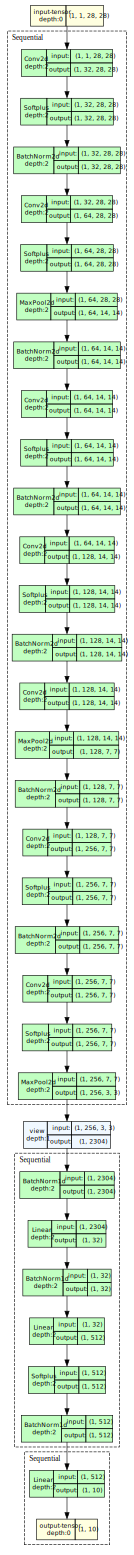

In [28]:
import torchvision
from torchview import draw_graph
net2 = Fashion_MNIST_CNN()

#model_graph = draw_graph(net2, input_size=(1,3,64,64), expand_nested=True)
model_graph = draw_graph(net2, input_size=(1,1,28,28), expand_nested=True)
model_graph.visual_graph
